## Task 0 - Data ingestion

In [49]:
import duckdb
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

with duckdb.connect("data/sakila.duckdb") as conn:
    description = conn.sql("DESC;").df()
    films = conn.sql("FROM staging.film;").df()

films.head(3)

,film_id,title,description,release_year,language_id,original_language_id,rental_duration,rental_rate,length,replacement_cost,rating,special_features,last_update,_dlt_load_id,_dlt_id
0,1,ACADEMY DINOSAUR,A Epic Drama of a Feminist And a Mad Scientist...,2006,1,<NA>,6,0.99,86,20.99,PG,"Deleted Scenes,Behind the Scenes",2021-03-06 15:52:00,1765525956.1897452,cgylPPbhRVV/rw
1,2,ACE GOLDFINGER,A Astounding Epistle of a Database Administrat...,2006,1,<NA>,3,4.99,48,12.99,G,"Trailers,Deleted Scenes",2021-03-06 15:52:00,1765525956.1897452,AjD0bEu6ESU4Cg
2,3,ADAPTATION HOLES,A Astounding Reflection of a Lumberjack And a ...,2006,1,<NA>,7,2.99,50,18.99,NC-17,"Trailers,Deleted Scenes",2021-03-06 15:52:00,1765525956.1897452,Tsls5T4c/V99Kg


In [50]:
description.head()

,database,schema,name,column_names,column_types,temporary
0,sakila,staging,_dlt_loads,"[load_id, schema_name, status, inserted_at, sc...","[VARCHAR, VARCHAR, BIGINT, TIMESTAMP WITH TIME...",False
1,sakila,staging,_dlt_pipeline_state,"[version, engine_version, pipeline_name, state...","[BIGINT, BIGINT, VARCHAR, VARCHAR, TIMESTAMP W...",False
2,sakila,staging,_dlt_version,"[version, engine_version, inserted_at, schema_...","[BIGINT, BIGINT, TIMESTAMP WITH TIME ZONE, VAR...",False
3,sakila,staging,actor,"[actor_id, first_name, last_name, last_update,...","[DECIMAL(38,9), VARCHAR, VARCHAR, TIMESTAMP, V...",False
4,sakila,staging,address,"[address_id, address, address2, district, city...","[BIGINT, VARCHAR, VARCHAR, VARCHAR, BIGINT, VA...",False


In [51]:
description["column_names"][5]

array(['category_id', 'name', 'last_update', '_dlt_load_id', '_dlt_id'],
      dtype=object)

# Task 1 - EDA in python

### Create a function to connect to sakila.duckdb and test it with assignment A - show title and length for movies longer than 3 hours:

In [52]:
def query_sakila(query: str, duckdb_path = "data/sakila.duckdb"):
    with duckdb.connect(duckdb_path) as conn:
        df = conn.sql(query=query).df()

    return df

query_sakila("""
            SELECT title, length 
            FROM staging.film
            WHERE length > 180;
            """).head()

,title,length
0,ANALYZE HOOSIERS,181
1,BAKED CLEOPATRA,182
2,CATCH AMISTAD,183
3,CHICAGO NORTH,185
4,CONSPIRACY SPIRIT,184


### Which movies have the word "love" in its title? 

In [ ]:
query_sakila("""SELECT title, rating, length, description
            FROM staging.film
            WHERE regexp_matches(title, '(?i)(^|[^A-Za-z])LOVE([^A-Za-z]|$)');
            """).head()

,title,rating,length,description
0,GRAFFITI LOVE,PG,117,A Unbelieveable Epistle of a Sumo Wrestler And...
1,IDAHO LOVE,PG-13,172,A Fast-Paced Drama of a Student And a Crocodil...
2,INDIAN LOVE,NC-17,135,A Insightful Saga of a Mad Scientist And a Mad...
3,LAWRENCE LOVE,NC-17,175,A Fanciful Yarn of a Database Administrator An...
4,LOVE SUICIDES,R,181,A Brilliant Panorama of a Hunter And a Explore...


### Calculate the following statistics on movie length:
- shortest
- average
- median
- longest

In [ ]:
df = query_sakila("""SELECT 
            ROUND(MIN(length), 0):: INTEGER as shortest_movie_min,
            ROUND(AVG(length), 0):: INTEGER AS average_movie_length_min,
            ROUND(MEDIAN(length), 0):: INTEGER AS median_movie_length_min,
            ROUND(MAX(length), 0):: INTEGER AS longest_movie_min
            FROM staging.film
            ;
            """)

df.style.hide(axis="index")

shortest_movie_min,average_movie_length_min,median_movie_length_min,longest_movie_min
46,115,114,185


### Show the 10 most expensive movies to rent per day

In [ ]:
df = query_sakila("""SELECT 
            title, 
            ROUND(rental_rate / rental_duration, 2) AS rent_per_day
            FROM staging.film
            ORDER BY rent_per_day DESC
            ;
            """).head(10)

df.style.format({"rent_per_day": "${:.2f}"})    # To get this format I have used an LLM for help

,title,rent_per_day
0,PATHS CONTROL,$1.66
1,BACKLASH UNDEFEATED,$1.66
2,BEHAVIOR RUNAWAY,$1.66
3,VIRTUAL SPOILERS,$1.66
4,TEEN APOLLO,$1.66
5,TELEGRAPH VOYAGE,$1.66
6,BILKO ANONYMOUS,$1.66
7,HEARTBREAKERS BRIGHT,$1.66
8,CLERKS ANGELS,$1.66
9,TIES HUNGER,$1.66


### Show the top 10 actors who has played in most movies

In [75]:
query_sakila("""SELECT 
            a.first_name || ' ' || a.last_name AS actor,
            COUNT(DISTINCT f.film_id) AS number_of_movies
            FROM staging.film f
               LEFT JOIN staging.film_actor fa ON f.film_id = fa.film_id
               LEFT JOIN staging.actor a ON a.actor_id = fa.actor_id
            GROUP BY actor
            ORDER BY number_of_movies DESC
            ;
            """).head(10)

,actor,number_of_movies
0,SUSAN DAVIS,54
1,GINA DEGENERES,42
2,WALTER TORN,41
3,MARY KEITEL,40
4,MATTHEW CARREY,39
5,SANDRA KILMER,37
6,SCARLETT DAMON,36
7,VAL BOLGER,35
8,UMA WOOD,35
9,ANGELA WITHERSPOON,35


### Exploring the dataset. Questions to investigate:
- Where are the stores with most employees located?
- What are each store's top 5 categories of movies currently rented?
- Which store has the most active customers?
- On which day of the week are most films rented?
- Rentals per month in year 2005

### Where are the stores with most employees located?

In [64]:
query_sakila("""SELECT 
            st.store_id AS store,
            c.city AS store_location,
            COUNT(staff_id) AS number_of_staff
            FROM staging.staff s
               LEFT JOIN staging.store st ON s.store_id = st.store_id
               LEFT JOIN staging.address a ON st.address_id = a.address_id
               LEFT JOIN staging.city c ON a.city_id = c.city_id
            GROUP BY store_location, store
            ORDER BY store
            ;
            """)

,store,store_location,number_of_staff
0,1,Lethbridge,1
1,2,Woodridge,1


### What are each store's top 5 categories of movies currently rented?


In [ ]:
df = query_sakila(""" 
            (           
            SELECT 
               s.store_id AS store,
               c.name AS category_name,
               COUNT(*) AS number_of_rentals
            FROM staging.store s
               LEFT JOIN staging.inventory i ON i.store_id = s.store_id
               LEFT JOIN staging.rental r ON r.inventory_id = i.inventory_id
               LEFT JOIN staging.film f ON f.film_id = i.film_id
               LEFT JOIN staging.film_category fc ON fc.film_id = f.film_id
               LEFT JOIN staging.category c ON c.category_id = fc.category_id
            WHERE 
               rental_date IS NOT NULL 
               AND return_date IS NULL
               AND store = 1
            GROUP BY store, c.name
            ORDER BY number_of_rentals DESC
            LIMIT 5
            )
            UNION ALL
            (
            SELECT
               s.store_id AS store,
               c.name AS category_name,
               COUNT(*) AS number_of_rentals
            FROM staging.store s
               LEFT JOIN staging.inventory i ON i.store_id = s.store_id
               LEFT JOIN staging.rental r ON r.inventory_id = i.inventory_id
               LEFT JOIN staging.film f ON f.film_id = i.film_id
               LEFT JOIN staging.film_category fc ON fc.film_id = f.film_id
               LEFT JOIN staging.category c ON c.category_id = fc.category_id
            WHERE 
               rental_date IS NOT NULL 
               AND return_date IS NULL
               AND store = 2
            GROUP BY store, c.name
            ORDER BY number_of_rentals DESC
            LIMIT 5
            )
            ORDER BY store, number_of_rentals DESC
            ;
            """)

df.style.hide(axis="index")

store,category_name,number_of_rentals
1,Animation,12
1,Action,9
1,Music,8
1,Games,7
1,Sports,7
2,New,9
2,Horror,9
2,Animation,9
2,Sports,8
2,Action,8


### Which store has the most customers?

In [65]:
query_sakila("""SELECT 
            store_id AS store,
            COUNT(active) AS active_customers
            FROM staging.customer
            WHERE active = 1
            GROUP BY store
            ORDER BY store
            ;
            """)

,store,active_customers
0,1,318
1,2,266


### On which day of the week in year 2005 are most films rented?

In [ ]:
df = query_sakila("""SELECT 
            strftime(rental_date, '%A') AS day_of_the_week,
            COUNT(rental_date) AS number_of_rentals,
            ROUND(number_of_rentals * 100.0 / SUM(number_of_rentals) OVER (), 1) || ' %' AS percentage_of_total 
            FROM staging.rental
            WHERE YEAR(rental_date) = 2005
            GROUP BY day_of_the_week
            ORDER BY number_of_rentals DESC
            ;
            """)

df.style.hide(axis="index")

day_of_the_week,number_of_rentals,percentage_of_total
Sunday,2320,14.6 %
Saturday,2311,14.6 %
Tuesday,2281,14.4 %
Friday,2272,14.3 %
Monday,2247,14.2 %
Wednesday,2231,14.1 %
Thursday,2200,13.9 %


### Number of rentals per month in year 2005

In [ ]:
df = query_sakila("""SELECT 
            strftime(rental_date, '%B') AS month,
            COUNT(rental_date) AS number_of_rentals,
            ROUND(number_of_rentals * 100.0 / SUM(number_of_rentals) OVER (), 1) || ' %' AS percentage_of_total
            FROM staging.rental
            WHERE YEAR(rental_date) = 2005
            GROUP BY month
            ORDER BY month DESC
            ;
            """)

df.style.hide(axis="index")

month,number_of_rentals,percentage_of_total
May,1156,7.3 %
June,2311,14.6 %
July,6709,42.3 %
August,5686,35.8 %


# Task 2 - graphs

### Show the top 5 customers by total spend

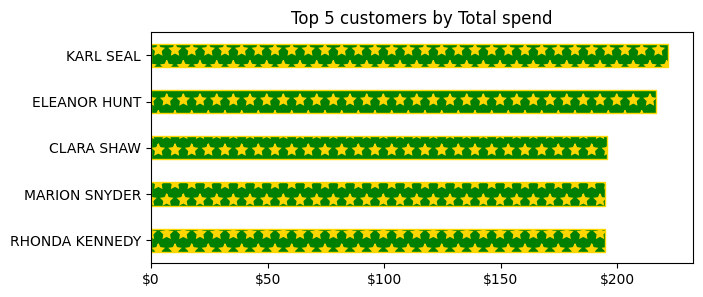

In [ ]:
total_customer_spend = query_sakila("""SELECT 
            c.first_name || ' ' || c.last_name AS customer_name,
            SUM(p.amount) AS total_spend
            FROM staging.payment p
            LEFT JOIN staging.customer c ON p.customer_id = c.customer_id
            GROUP BY customer_name
            ORDER BY total_spend DESC
            ;
            """).head(5)

ax = total_customer_spend.plot(
    x="customer_name", 
    y="total_spend", 
    kind="barh",
    figsize=(7,3),
    color="green",
    hatch="*",
    edgecolor="gold",
    legend=False
    )

# For the following graph adjustments, I used an LLM for help.

ax.invert_yaxis()
ax.set_ylabel("")
ax.xaxis.set_major_formatter(FuncFormatter(lambda v, _: f'${v:.0f}'))

ax.set_title("Top 5 customers by Total spend")

plt.show()

### Total revenue per film category

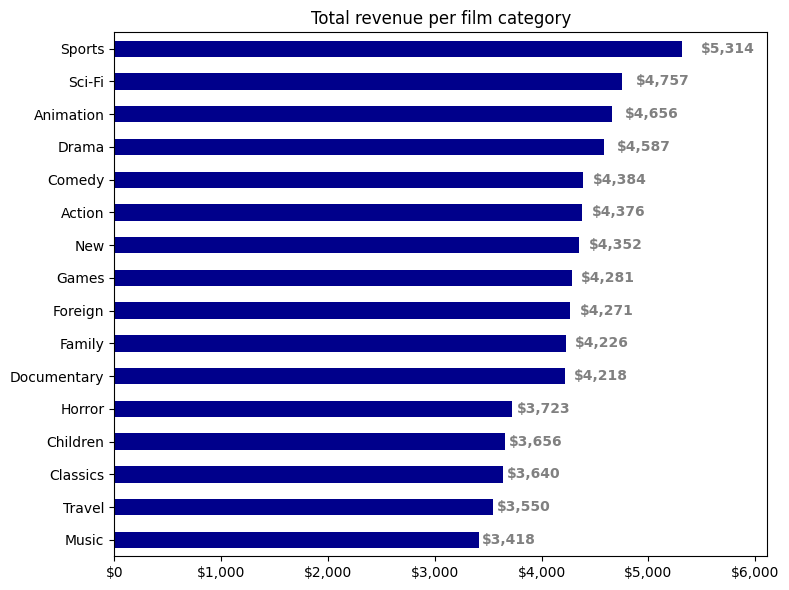

In [ ]:
total_revenue_per_category = query_sakila("""SELECT 
            c.name AS film_category,
            SUM(p.amount) AS total_revenue
            FROM staging.category c
            LEFT JOIN staging.film_category fc ON c.category_id = fc.category_id
            LEFT JOIN staging.film f ON fc.film_id = f.film_id
            LEFT JOIN staging.inventory i ON f.film_id = i.film_id
            LEFT JOIN staging.rental r ON i.inventory_id = r.inventory_id
            LEFT JOIN staging.payment p ON r.rental_id = p.rental_id
            WHERE p.amount IS NOT NULL
            GROUP BY film_category
            ORDER BY total_revenue DESC
            ;
            """)

ax = total_revenue_per_category.plot(
    x="film_category",
    y="total_revenue",
    kind="barh",
    figsize=(8,6),
    color="darkblue",
    legend=False
)

# For the following graph adjustments, I used an LLM for help.

max_value = total_revenue_per_category["total_revenue"].max()
ax.set_xlim(0, max_value * 1.15)

ax.invert_yaxis()
ax.set_ylabel("")
ax.xaxis.set_major_formatter(FuncFormatter(lambda v, _: f'${v:,.0f}'))

for bar in ax.patches:
    width = bar.get_width()
    y = bar.get_y() + bar.get_height() / 2

    ax.text(
        width + (width * 0.08),
        y,
        f"${width:,.0f}",
        ha="center",
        va="center",
        color="grey",
        fontweight="bold"
    )

ax.set_title("Total revenue per film category")

plt.tight_layout()
plt.show()